In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split


In [3]:
f_heights = np.random.normal(152, 5, 1000)
m_heights = np.random.normal(166, 5, 1000)

# Sort female heights and add outliers (increase 50 largest values by 10 cm)
sorted_f_heights = np.sort(f_heights)
for i in range(50):
    sorted_f_heights[999-i] += 10

# Convert to pandas series
f_heights_series = pd.Series(sorted_f_heights)
m_heights_series = pd.Series(m_heights)

# Sizes
num_females = f_heights_series.size
num_males = m_heights_series.size
total = num_females + num_males

print(f_heights_series.head())
print(m_heights_series.head())


0    135.969879
1    136.372114
2    136.445012
3    136.809516
4    137.051238
dtype: float64
0    170.016971
1    163.088392
2    166.210441
3    170.533190
4    158.520717
dtype: float64


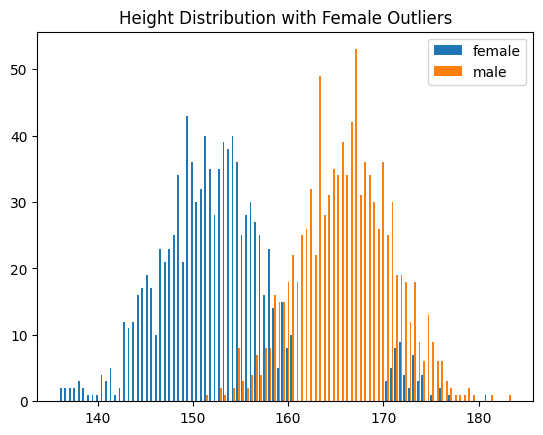

In [4]:
plt.hist([f_heights_series, m_heights_series], bins=100, label=['female', 'male'])
plt.legend()
plt.title("Height Distribution with Female Outliers")
plt.show()


In [5]:
def z_score(heights, threshold=3):
    mean = heights.mean()
    std = heights.std()
    z_scores = (heights - mean) / std
    return heights[abs(z_scores) < threshold]


In [6]:
female_train_with_outliers, female_test_with_outliers = train_test_split(f_heights_series, test_size=0.2)
male_train_with_outliers, male_test_with_outliers = train_test_split(m_heights_series, test_size=0.2)

# Remove outliers from female training set
female_train_without_outliers = z_score(female_train_with_outliers)


In [7]:
def threshold_classifier(threshold_increment, f_heights, m_heights):
    lower_bound = m_heights.min()
    upper_bound = f_heights.max()
    total = f_heights.size + m_heights.size

    new_lower_bound = np.floor(lower_bound)
    new_upper_bound = np.ceil(upper_bound)
    
    best_rate = 100.0
    best_threshold = new_lower_bound
    
    for threshold in np.arange(new_lower_bound, new_upper_bound+1, threshold_increment):
        misclassified_females = sum(f_heights > threshold)
        misclassified_males = sum(m_heights < threshold)
        mis_rate = 100.0 * (misclassified_females + misclassified_males) / total
        if mis_rate < best_rate:
            best_threshold = threshold
            best_rate = mis_rate
    return [best_threshold, best_rate]




In [8]:
def predict_threshold_classifier(female_test, male_test, threshold_result):
    total = female_test.size + male_test.size
    threshold = threshold_result[0]
    male_errors = np.sum(male_test < threshold)
    female_errors = np.sum(female_test > threshold)
    mis_rate = 100 * (male_errors + female_errors) / total
    return mis_rate

In [ ]:

# With outliers
threshold_results = threshold_classifier(0.5, female_train_with_outliers, male_train_with_outliers)
print("Train with outliers:", threshold_results)
print("Train misclassification (with outliers):", predict_threshold_classifier(female_train_with_outliers, male_train_with_outliers, threshold_results))

#without outliers
threshold_results_no = threshold_classifier(0.5, female_train_without_outliers, male_train_with_outliers)
print("Train without outliers:", threshold_results_no)
print("Train misclassification (without outliers):", predict_threshold_classifier(female_train_without_outliers, male_train_with_outliers, threshold_results_no))

#test
print("Test misclassification (with outliers):", predict_threshold_classifier(female_test_with_outliers, male_test_with_outliers, threshold_results))
print("Test misclassification (without outliers):", predict_threshold_classifier(female_test_with_outliers, male_test_with_outliers, threshold_results_no))


Train with outliers: [np.float64(158.5), 7.625]
Train misclassification (with outliers): 7.625
Train without outliers: [np.float64(158.5), 6.632975363234365]
Train misclassification (without outliers): 6.632975363234365
Test misclassification (with outliers): 8.0
Test misclassification (without outliers): 8.0


In [ ]:

def probability_classifier(f_heights, m_heights):
    total = f_heights.size + m_heights.size
    male_mean, male_sd = m_heights.mean(), m_heights.std()
    female_mean, female_sd = f_heights.mean(), f_heights.std()
    
    mis_females = sum(norm.pdf(h, female_mean, female_sd) < norm.pdf(h, male_mean, male_sd) 
                      for h in f_heights)
    mis_males = sum(norm.pdf(h, male_mean, male_sd) < norm.pdf(h, female_mean, female_sd) 
                    for h in m_heights)

    mis_rate = 100.0 * (mis_females + mis_males) / total
    return mis_rate, male_mean, male_sd, female_mean, female_sd


In [ ]:
def predict_probability(male_set, female_set, male_mean, male_std, female_mean, female_std):
    total = male_set.size + female_set.size
    mis_females = sum(norm.pdf(h, female_mean, female_std) < norm.pdf(h, male_mean, male_std) for h in female_set)
    mis_males = sum(norm.pdf(h, male_mean, male_std) < norm.pdf(h, female_mean, female_std) for h in male_set)
    return 100.0 * (mis_females + mis_males) / total

# Train
mis_with, male_mean, male_std, female_mean, female_std = probability_classifier(female_train_with_outliers, male_train_with_outliers)
mis_without, male_mean_no, male_std_no, female_mean_no, female_std_no = probability_classifier(female_train_without_outliers, male_train_with_outliers)



In [12]:
print("Probability misclassification (train with outliers):", mis_with)
print("Probability misclassification (train without outliers):", mis_without)

# Test
print("Probability misclassification (test with outliers):", predict_probability(male_test_with_outliers, female_test_with_outliers, male_mean, male_std, female_mean, female_std))
print("Probability misclassification (test without outliers):", predict_probability(male_test_with_outliers, female_test_with_outliers, male_mean_no, male_std_no, female_mean_no, female_std_no))


Probability misclassification (train with outliers): 8.0
Probability misclassification (train without outliers): 7.138344914718888
Probability misclassification (test with outliers): 8.75
Probability misclassification (test without outliers): 8.5


In [13]:
def quantize(heights, interval_len):
    labels = np.floor(heights / interval_len)
    return labels.value_counts()


In [14]:
def local_classifier(interval_len, f_heights, m_heights):
    total = f_heights.size + m_heights.size
    male_q = quantize(m_heights, interval_len)
    female_q = quantize(f_heights, interval_len)
    
    lower = int(male_q.index.min())
    upper = int(female_q.index.max())
    total_mis = 0
    results = []
    
    for interval in range(lower, upper, 1):
        f_count = female_q.get(interval, 0)
        m_count = male_q.get(interval, 0)
        error = min(f_count, m_count)
        total_mis += error
        results.append({"interval": interval, "female_count": f_count, "male_count": m_count})
    
    print("Misclassification =", 100.0 * total_mis / total)
    return pd.DataFrame(results)

In [15]:
local_error_with = local_classifier(2, female_train_with_outliers, male_train_with_outliers)
local_error_without = local_classifier(2, female_train_without_outliers, male_train_with_outliers)

Misclassification = 8.0
Misclassification = 7.012002526847757
